## Filtering  

This notebook corresponds to the development of Script chapter 3.4.1. from the main text of the dissertation titled: Nobel Microorganisms Associated with Corrosion by this Author. This notebook performs preprocessing and analysis of bacterial data associated with corrosion. The main tasks include filtering taxa by abundance, identifying influential GIDs based on occurrence and significance tests, and visualizing results. Detailed methodological steps are outlined in Chapter 3.3 of the dissertation.

Statistical Analysis: A non-parametric test is performed to determine if there are any bacteria that are significantly associated with corrosion in each traffic light category.   
Unique GIDs for each category:   
filtered_gids_1: GIDs unique to category 1  
filtered_gids_2: GIDs unique to category 2  
filtered_gids_3: GIDs unique to category 3  
selected_gids_23: manually selected GIDs present in categories 2 and 3  
Combined sets:  
tax_unique: Union of filtered_gids_1, filtered_gids_2, and filtered_gids_3 (only the unique ones from each category)  
tax_unique_plus_23: Union of uniques_gids and selected_gids_23 (combines all unique GIDs plus those shared between categories 2 and)   
Taxa_OLS_all: Gids found to be statistically significant through OLS regression analysis of the complete dataset  
Taxa_Influencers_OLS: Subset of Jointax namely 'Influencers_OLS' Gids found to be statistically significant through OLS regression   plus they also abundant, with a concentration of 2% or higher and found to have also frecuency across the sample, more thatn 3 occurrencies.  

Importing libraries for data manipulation, visualization, and statistical analysis.

In [229]:
# Import the pandas library for data manipulation
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import ols

In [230]:
# Read the excel file coming from notebook Splitdf.ipynb
traffic_1  = pd.read_csv('data/abundance_1.csv', dtype={i: float for i in range(1, 18)})
traffic_2  = pd.read_csv('data/abundance_2.csv', dtype={i: float for i in range(1, 33)})
traffic_3  = pd.read_csv('data/abundance_3.csv', dtype={i: float for i in range(1, 22)})

In [231]:
# Making sure the column GID is taken as an integer type
traffic_1 ["GID"] = traffic_1["GID"].astype("int")
traffic_2 ["GID"] = traffic_2["GID"].astype("int")
traffic_3 ["GID"] = traffic_3["GID"].astype("int")

Filtering by abundance threshold

In [232]:
def filter_values_by_threshold(traffic, threshold_percentage):
    """
    Filters taxa exceeding a specified abundance threshold
    """
    # Create an empty DataFrame with the same columns as the original DataFrame, which only contain the traffic data without the 6 taxa levels
    filtered_abundance = pd.DataFrame(columns=traffic.columns)

    # Loop through each column (sample) in data, excluding the 'GID' column
    for column in traffic.columns[1:]:
        # Calculate the threshold value for the current column based on the percentage
        threshold = traffic[column].sum() * (threshold_percentage / 100)

        # Filter the rows in the current column where the value is greater than or equal to the threshold
        filtered_data = traffic[traffic[column] >= threshold]

        # Append the filtered_data to the filtered_abundance DataFrame
        filtered_abundance = filtered_abundance.append(filtered_data, ignore_index=True)

    # Drop duplicates in the 'GID' column and reset the index
    filtered_abundance = filtered_abundance.drop_duplicates(subset='GID', keep='first').reset_index(drop=True)

    return filtered_abundance

From the filtered abundance data based on the threshold, we derive the frequency of occurrence for each genus across samples, categorized by their corrosion risk label.

In [233]:
def get_frequency_GID(filtered_abundance):
    """
    Count the occurrences of each GID in the samples and merge the influence counts with the original DataFrame.
    Returns:
    pd.DataFrame: A DataFrame with the added 'Influence' column, sorted by 'Influence' in descending order.
    """

    # Initialize an empty dictionary to store the GID counts
    gid_counts = {}

    # Loop through each column (sample) in filtered_abundance, excluding the 'GID' column
    for column in filtered_abundance.columns[1:]:
        # Count the occurrences of each GID in the current column and update the gid_counts dictionary
        for index, row in filtered_abundance.iterrows():
            if row[column] != 0:
                gid = row['GID']
                gid_counts[gid] = gid_counts.get(gid, 0) + 1

    # Create a DataFrame with the 'GID' and 'Influence' columns from the gid_counts dictionary
    influence_df = pd.DataFrame(list(gid_counts.items()), columns=['GID', 'Influence'])

    # Merge the influence_df DataFrame with the filtered_abundance DataFrame on the 'GID' column
    influencers_genus = filtered_abundance.merge(influence_df, on='GID')

    # Sort the influence_genera DataFrame by the 'Influence' column in descending order
    influencers_genus = influencers_genus.sort_values(by='Influence', ascending=False).reset_index(drop=True)

    return influencers_genus

In [234]:
# Filter values by threshold
threshold_percentage = 2

filtered_abundance_1 = filter_values_by_threshold(traffic_1, threshold_percentage)
filtered_abundance_2 = filter_values_by_threshold(traffic_2, threshold_percentage)
filtered_abundance_3 = filter_values_by_threshold(traffic_3, threshold_percentage)

# Get the frequency of GID
influencers_genus_1 = get_frequency_GID(filtered_abundance_1)
influencers_genus_2 = get_frequency_GID(filtered_abundance_2)
influencers_genus_3 = get_frequency_GID(filtered_abundance_3)

The statistical analysis involves:

 * Multivariate Analysis of Variance (MANOVA):
    Used to test if the mean abundance of taxa differs across corrosion risk categories (traffic lights, TL1-TL3).
    Helps identify genera strongly associated with specific categories.
* Post-hoc Tests:
    If MANOVA results are significant, post-hoc tests (e.g., Tukey's HSD) determine which categories differ significantly.
* Ordinary Least Squares (OLS) Regression:
    Used to assess the relationship between taxa abundance and corrosion risk labels (Categories).
    Returns coefficients and p-values for each genus, identifying statistically significant contributors.
   
The influencers_genus_1, influencers_genus_2, and influencers_genus_3 are selected GIDs filtered based on high abundance percentages and frequency thresholds. These represent the most relevant GIDs per category. A combined dataframe, dfs, is created by appending all columns from the selected influencers into a single wide-format dataframe. This is later melted into a long-format dataframe and so later there will be melted and concatenated to be on long format and be analysed for the statistic test OLS.

In [235]:
# List of dataframes
dfs = [influencers_genus_1, influencers_genus_2, influencers_genus_3]
categories = ["TL1", "TL2", "TL3"]

dfs_T = []

for df, category in zip(dfs, categories):
    # Set "GID" as index and rename the index to "Sites"
    df = df.set_index("GID").rename_axis("Sites")
       
    # Transpose the dataframe
    df_T = df.T
    
    # Drop the last row
    df_T = df_T.drop(df_T.index[-1])
    
    # Add the "Category" column
    df_T["Category"] = category
    
    # Reorder columns to have "Category" as the first column
    cols = ['Category'] + [col for col in df_T.columns if col != 'Category']
    df_T = df_T[cols]
        
    dfs_T.append(df_T)

# Transformed dataframes
influencers_1_T, influencers_2_T, influencers_3_T = dfs_T

The data here joined as dfs come from the previous arangment and comprise 77 genera from influencers_genus_1, 92 genera from influencers_genus_2 and 85 genera from influencers_genus_3. This are selected genera and could comprise Genus that are on all the three df or in two or only one of them. In total there are 254 genera coming from 882.

In [236]:
print(influencers_genus_1.shape, influencers_genus_2.shape, influencers_genus_3.shape)

(77, 19) (92, 34) (85, 23)


## Ordinary Least Squares (OLS) regression analysis.
__Coefficients__: These represent the change in the dependent variable for a one-unit change in the predictor variable, all other predictors being held constant.

__p-values:__ These indicate the significance of each coefficient. A small p-value (typically ≤ 0.05) indicates that you can reject the null hypothesis and that the predictor has a statistically significant association with the dependent variable.

In [237]:
# Melt each dataframe
melted_dfs = [df.reset_index().melt(id_vars=["index", "Category"], value_name="Abundance", var_name="GID").rename(columns={"index": "Sites"}) for df in dfs_T]

# Concatenate the melted dataframes
long_df = pd.concat(melted_dfs, ignore_index=True)
long_df.shape

(6038, 4)

In [238]:
long_df.head()

,Sites,Category,GID,Abundance
0,site_2,TL1,110,1.8592
1,site_3,TL1,110,3.0935
2,site_4,TL1,110,2.5740
3,site_5,TL1,110,2.7094
4,site_17,TL1,110,0.3176


In [239]:
# Convert the long format back to wide format for MANOVA
wide_df = long_df.pivot_table(index=["Sites", "Category"], columns="GID", values="Abundance", fill_value=0).reset_index()
# Convert 'Category' to numerical values
wide_df['Category'] = wide_df['Category'].replace({'TL1': 1, 'TL2': 2, 'TL3': 3})

In [240]:
def significant_gids_v2(data, alpha=0.05):
    """
    Identify GIDs that are significantly associated with the 'Category' variable.
    
    Parameters:
    - data: DataFrame with GIDs as columns, 'Category' column indicating site category, and sites as rows.
    - alpha: Significance level (default is 0.05).
    
    Returns:
    - Dictionary with GIDs as keys. Each key's value is another dictionary with 'Coefficient' and 'P-value'.
    """
    # Separate the dependent variables (GIDs) and the independent variable (Category)
    endog = data.drop(columns=['Sites', 'Category'])
    endog = endog.astype(float)  # Convert all dependent variables to float
    
    # Independent variables (with constant)
    exog = sm.add_constant(data['Category'])
    exog = exog.astype(float)  # Convert all columns in exog to float
    
    significant_results = {}
    
    for gid in endog.columns:
        y = endog[gid]
        # Build the regression model
        model = sm.OLS(y, exog).fit()
        # Check if p-value for 'Category' is significant
        if model.pvalues['Category'] < alpha:
            significant_results[gid] = {
                'Coefficient': model.params['Category'],
                'P-value': model.pvalues['Category']
            }
    
    return significant_results

In [241]:
wide_df.head()

GID,Sites,Category,6,7,13,17,20,23,29,30,...,800,804,827,853,859,862,863,864,867,871
0,site_1,3,0.4308,0.5170,0.0000,6.2473,0.0431,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,4.6101,0.0000,0.0000,0.0000,0.0000,0.0000
1,site_10,2,0.0000,0.0000,49.5300,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,site_11,3,0.0000,1.1512,0.0000,0.1535,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1535,0.0000
3,site_12,3,1.7169,0.0000,0.0000,0.2453,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,20.7219,0.0000
4,site_13,3,0.0000,1.9849,0.0000,0.9528,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3374,0.0000


### Influencers_OLS 
The significant Genera using OLS on the influencers dataframe gives as a result dataframe Influencers_OLS

In [242]:
# Get the significant GIDs
sig_gids = significant_gids_v2(wide_df, alpha=0.05)

# Print the significant GIDs
for gid, values in sig_gids.items():
    #print(f"GID: {gid}, Coefficient: {values['Coefficient']:.4f}, P-value: {values['P-value']:.4f}")
    print(f"GID: {gid}")

GID: 23
GID: 91
GID: 214
GID: 229
GID: 334
GID: 351
GID: 375
GID: 408
GID: 471
GID: 526
GID: 549
GID: 565
GID: 584
GID: 625
GID: 678
GID: 712
GID: 725
GID: 863
GID: 864
GID: 871


In [243]:
# Convert the column headers (names) of wide_df to strings
gids_filtered = set(map(str, sig_gids))
# Convert the column headers of wide_df to strings
wide_df.columns = wide_df.columns.astype(str)

# Now, filter the dataframe
filtered_columns = ['Sites', 'Category'] + list(gids_filtered)
Influencers_OLS = wide_df[filtered_columns]

The Influencers_OLS dataset contains genera with statistically significant p-values, indicating their potential as biomarkers for corrosion risk

### OLS_all in the whole data with 880 genera
With the whole df from the original data in Biotot, the significant Genera using OLS on the original dataframe gives as a result a df OLS_all

In [244]:
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
datos = pd.read_excel('data/Biotot.xlsx', sheet_name='Biotot', header=[0,1], dtype={i: float for i in range(8, 71)})
datos["GID"]= datos["GID"].astype(str)
whole = datos.iloc[:, 6:]

In [245]:
# Transpose the dataframe
whole_T = whole.T
whole_T = whole_T.reset_index()
# Set the second row as the header
whole_T.columns = whole_T.iloc[0]
whole_T = whole_T.drop(0)
# Rename the columns
whole_T = whole_T.rename(columns={"GID": "Sites", 0: "Category"})

In [246]:
whole_T.head()

,Sites,Category,1,2,3,4,5,6,7,8,...,873,874,875,876,877,878,879,880,881,882
1,site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.4308,0.5170,0.0000,...,0.0000,0.0000,0.0000,0.0215,0.0000,0.0000,0.0000,0.0000,0.0215,0.0000
2,site_2,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0190,0.3415,0.0000,...,0.0190,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0190,0.0000
3,site_3,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0246,0.3192,0.0000,...,0.0123,0.0000,0.0000,0.0123,0.0000,0.0000,0.0000,0.0000,0.0246,0.0123
4,site_4,1,0.0000,0.0000,0.0154,0.0000,0.0000,0.0176,0.2512,0.0000,...,0.0022,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0066,0.0022
5,site_5,1,0.0000,0.0000,0.0037,0.0000,0.0000,0.0221,0.5098,0.0000,...,0.0037,0.0000,0.0037,0.0000,0.0000,0.0000,0.0000,0.0000,0.0110,0.0037


In [247]:
# Get the significant GIDs
sig_gids_whole = significant_gids_v2(whole_T, alpha=0.05)

# Print the significant GIDs
for gid, values in sig_gids_whole.items():
    #print(f"GID: {gid}, Coefficient: {values['Coefficient']:.4f}, P-value: {values['P-value']:.4f}")
    print(f"GID: {gid}")

GID: 23
GID: 79
GID: 88
GID: 90
GID: 91
GID: 92
GID: 140
GID: 201
GID: 214
GID: 229
GID: 334
GID: 337
GID: 342
GID: 410
GID: 426
GID: 428
GID: 470
GID: 480
GID: 494
GID: 541
GID: 549
GID: 565
GID: 584
GID: 605
GID: 625
GID: 657
GID: 678
GID: 712
GID: 725
GID: 771
GID: 799
GID: 871


To compare filtered and unfiltered data, dictionary keys (GIDs) from both datasets were converted to sets. A new dataframe was created to evaluate statistically significant GIDs from both lists. This allows us to assess which method of selection is more suitable.

In [248]:
# Convert the column headers (names) of wide_df to strings
gids_whole_df = set(map(str, sig_gids_whole))
# Convert the column headers of wide_df to strings
whole_T.columns =whole_T.columns.astype(str)

# Now, filter the dataframe
whole_GIDs_columns = ['Sites', 'Category'] + list(gids_whole_df)
OLS_all= whole_T[whole_GIDs_columns]
print(f"""
Influencers_OLS: {Influencers_OLS.columns}
OLS_all.columns: {OLS_all.columns}
""")


Influencers_OLS: Index(['Sites', 'Category', '678', '565', '23', '864', '712', '214', '549',
       '625', '863', '229', '526', '584', '725', '408', '91', '351', '375',
       '334', '871', '471'],
      dtype='object', name='GID')
OLS_all.columns: Index(['Sites', 'Category', '678', '565', '410', '342', '771', '605', '23',
       '140', '712', '214', '90', '470', '92', '549', '625', '229', '79',
       '584', '725', '799', '657', '91', '428', '201', '426', '541', '334',
       '494', '88', '337', '871', '480'],
      dtype='object', name=0)



The OLS_all dataset contains genera with statistically significant p-values, without filtering coming from the original data, indicating their potential as biomarkers for corrosion risk

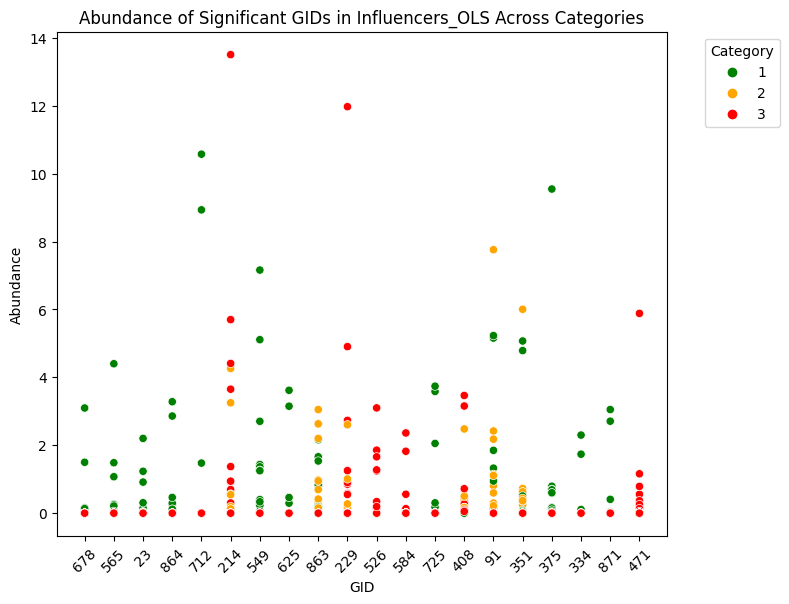

In [249]:
# Melt the dataframe
melted_df = Influencers_OLS.melt(id_vars=['Sites', 'Category'], 
                                value_vars= Influencers_OLS.columns[2:], 
                                var_name='GID', 
                                value_name='Abundance')
# Categories and colors
categories = [1, 2, 3]
colors = ['green', 'orange', 'red']

# Set the figure size
plt.figure(figsize=(8, 6))

# Use seaborn's barplot function for the visualization
sns.scatterplot(x='GID', y='Abundance', hue='Category', data=melted_df, 
            hue_order=categories, palette=colors)

# Set the title and labels
plt.title('Abundance of Significant GIDs in Influencers_OLS Across Categories')
plt.xlabel('GID')
plt.ylabel('Abundance')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

The scatterplot of significant GIDs in Influencers_OLS across categories highlights genera predominantly associated with Category 3, some with Categories 2 and 3, and others with Category 2. This selection approach shows potential merit, which will be further evaluated in the PCA notebook. Biological validation using known markers and clustering analysis will follow

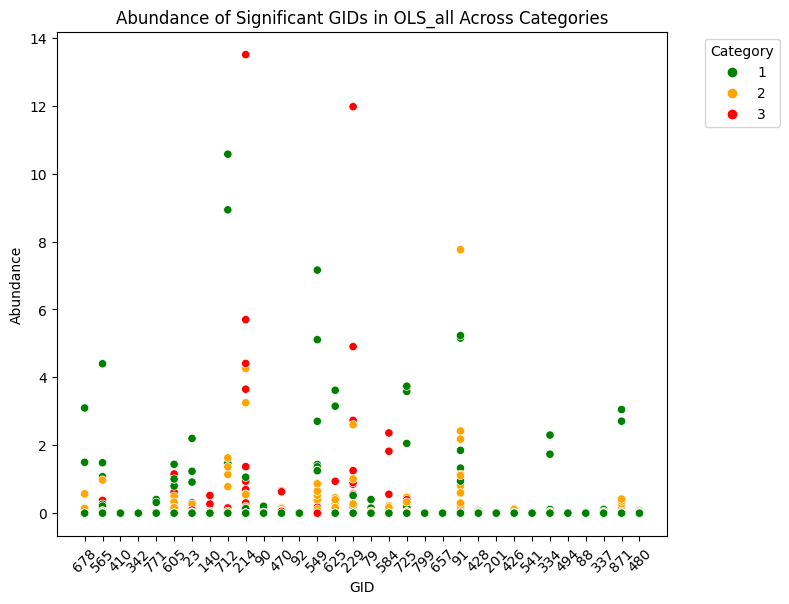

In [250]:
import seaborn as sns
# Melt the dataframe
melted_df = OLS_all.melt(id_vars=['Sites', 'Category'], 
                                value_vars= OLS_all.columns[2:], 
                                var_name='GID', 
                                value_name='Abundance')
# Categories and colors
categories = [1, 2, 3]
colors = ['green', 'orange', 'red']

# Set the figure size
plt.figure(figsize=(8, 6))

# Use seaborn's barplot function for the visualization
sns.scatterplot(x='GID', y='Abundance', hue='Category', data=melted_df, 
            hue_order=categories, palette=colors)

# Set the title and labels
plt.title('Abundance of Significant GIDs in OLS_all Across Categories')
plt.xlabel('GID')
plt.ylabel('Abundance')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

The plot of significant GIDs in OLS_all across categories shows overlaps with Influencers_OLS, as expected. However, Category 2 and 3 contributions appear less distinct visually. This highlights the importance of refining visualizations in subsequent analyses, such as PCA and clustering

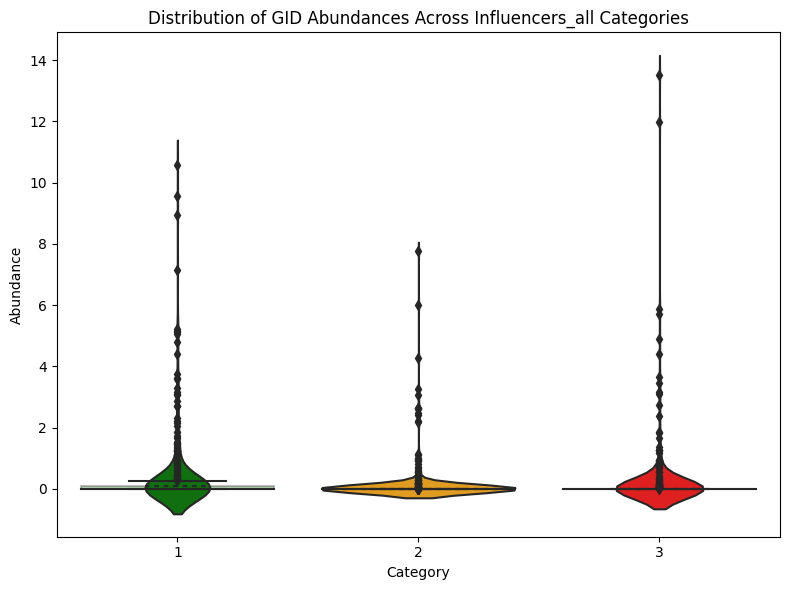

In [251]:
# Melt the dataframe
melted_df = Influencers_OLS.melt(id_vars=['Sites', 'Category'], 
                                value_vars=Influencers_OLS.columns[2:], 
                                var_name='GID', 
                                value_name='Abundance')

# Categories and colors
categories = [1, 2, 3]
colors = ['green', 'orange', 'red']

# Set the figure size
plt.figure(figsize=(8, 6))

# Use seaborn's boxplot function for the visualization
sns.boxplot(x='Category', y='Abundance', data=melted_df, palette=colors, boxprops=dict(alpha=.3))

# Swarmplot
#sns.swarmplot(x='Category', y='Abundance', data=melted_df, color=".25")
# Violin plot
sns.violinplot(x='Category', y='Abundance', data=melted_df, palette=colors, inner="quartile")

# Set the title and labels
plt.title('Distribution of GID Abundances Across Influencers_all Categories')
plt.xlabel('Category')
plt.ylabel('Abundance')

# Display the plot
plt.tight_layout()
plt.show()

The Influencers_OLS violin plots show non-homogeneous distribution across categories. Category 1 has a narrow diamond shape, with a smaller abundance distribution than Category 3, which is broader. Category 2 has a wide lip shape with the lowest abundance distribution.

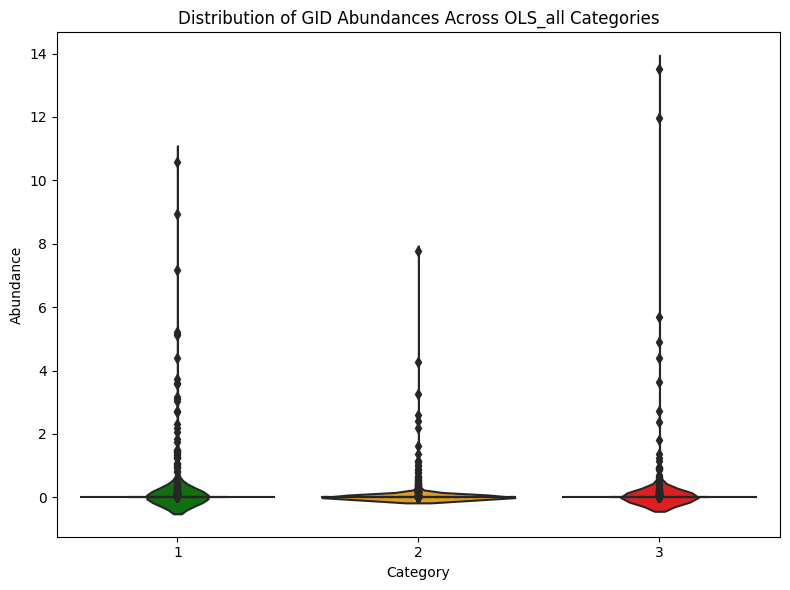

In [252]:
# Melt the dataframe
melted_whole = OLS_all.melt(id_vars=['Sites', 'Category'], 
                                value_vars=OLS_all.columns[2:], 
                                var_name='GID', 
                                value_name='Abundance')
melted_whole['Abundance'] = pd.to_numeric(melted_whole['Abundance'], errors='coerce')

# Categories and colors
categories = [1, 2, 3]
colors = ['green', 'orange', 'red']

# Set the figure size
plt.figure(figsize=(8, 6))

# Use seaborn's boxplot function for the visualization
sns.boxplot(x='Category', y='Abundance', data=melted_whole, palette=colors, boxprops=dict(alpha=.3))

# Violin plot
sns.violinplot(x='Category', y='Abundance', data=melted_whole, palette=colors, inner="quartile")

# Set the title and labels
plt.title('Distribution of GID Abundances Across OLS_all Categories')
plt.xlabel('Category')
plt.ylabel('Abundance')

# Display the plot
plt.tight_layout()
plt.show()


The violin plot of the df OLS_all in contrast with the Influencers_OLS, presents narrower distributions for Categories 2 and 3, with Category 2 being particularly thin. It is important to note that abundance is relative, not absolute. This limitation notwithstanding, Influencers_OLS appears more suitable for further analysis, while OLS_all adds little to the discussion

In [253]:
# Save to Excel 
Influencers_OLS.to_excel(f'data/Influencers_OLS.xlsx', index=True, engine='openpyxl')
OLS_all.to_excel(f'data/OLS_all.xlsx', index=True, engine='openpyxl')

This notebook has worked without the taxa metadata and in this step the dfs OLS_all and Influencers_OLS will be combined with the taxa identifiers to make new df taxa_OLS_all and taxa_Influencers_OLS, for further use.

In [254]:
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7] , dtype={**{i: str for i in range(0,2)},
                                                                        **{i:float for i in range(2, 884)}},  skiprows=[8]) # Somehow it was showing an empty row, so skiprow deletes it

# Making sure the sites and categories get read as they should
Jointax["Sites"]= Jointax["Sites"].astype(str)
Jointax["Category"]= Jointax["Category"].values.astype(int)
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
Jointax = Jointax.reset_index(drop=True)
#Setting the sites as index
Jointax = Jointax.set_index("Sites").reset_index()
# Deleting headers names of unnamed levels
Jointax.columns = Jointax.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
#Drop level of Kindom since it is boring
Jointax =Jointax.drop(Jointax.columns[1], axis=1)
#Correcting the Tuple-like Index
Jointax['Sites'] = Jointax['Sites'].map(lambda x: x[0] if isinstance(x, tuple) else x)
Jointax = Jointax.set_index("Sites")

In [255]:
# Create a set of the GIDs from the 'OLS_all' and 'Influencers_OLS' DataFrames
Gids_OlS_all = set(OLS_all.columns)
Gids_influencers_OLS = set(Influencers_OLS)

### Uniques and combined 2 and 3
We assume that if a genus belong to all the categories, we focus on the unique GIDs considering that may be more relevant to see the differences and perhaps more relevant regarding corrosion. If the GID were relevant, why then is not associated with a corrosion traffic light? if were relevant it should have also caused corrosion on the traffic light. So first we identify this common Genus/GIDs intersection so not to put them on the comparison.

In [256]:
whole_T.head()

,Sites,Category,1,2,3,4,5,6,7,8,...,873,874,875,876,877,878,879,880,881,882
1,site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.4308,0.5170,0.0000,...,0.0000,0.0000,0.0000,0.0215,0.0000,0.0000,0.0000,0.0000,0.0215,0.0000
2,site_2,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0190,0.3415,0.0000,...,0.0190,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0190,0.0000
3,site_3,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0246,0.3192,0.0000,...,0.0123,0.0000,0.0000,0.0123,0.0000,0.0000,0.0000,0.0000,0.0246,0.0123
4,site_4,1,0.0000,0.0000,0.0154,0.0000,0.0000,0.0176,0.2512,0.0000,...,0.0022,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0066,0.0022
5,site_5,1,0.0000,0.0000,0.0037,0.0000,0.0000,0.0221,0.5098,0.0000,...,0.0037,0.0000,0.0037,0.0000,0.0000,0.0000,0.0000,0.0000,0.0110,0.0037


In [257]:
# Function to load and preprocess data
def load_and_preprocess(file_path):
    # Load CSV and drop unnecessary columns
    df = pd.read_csv(file_path)
    df['GID'] = df['GID'].astype(int)  # Ensure GID is int
    df = df.set_index("GID")  # Set index 
    df = df.drop(columns='Unnamed: 0', axis=1, errors='ignore')
    return df

In [258]:
# Process DataFrames for unique_all categories
file_paths = ["data/unique_1.csv", "data/unique_2.csv", "data/unique_3.csv"]
dataframes = [load_and_preprocess(path) for path in file_paths]

In [259]:
file_path23 = ["data/uniques_23.csv"]
uniques_23 = load_and_preprocess(file_path23[0])

In [260]:
# Debug: Verify the index type and contents
for i, df in enumerate(dataframes, 1):
    print(f"DataFrame {i}: Index Type - {df.index.dtype}, Shape - {df.shape}")
    print(f"Index Sample (first 5): {list(df.index)[:5]}")

DataFrame 1: Index Type - int64, Shape - (84, 17)
Index Sample (first 5): [4, 15, 16, 21, 46]
DataFrame 2: Index Type - int64, Shape - (149, 32)
Index Sample (first 5): [2, 5, 22, 50, 61]
DataFrame 3: Index Type - int64, Shape - (106, 21)
Index Sample (first 5): [10, 14, 19, 25, 54]


In [261]:
# Get all unique GIDs from the DataFrames
uniques_cat_gids = set.union(*[set(df.index) for df in dataframes])
# Combine unique GIDs with common GIDs from Categories 2 and 3 plus uniques cat
uniques_plus_23_gids = uniques_23.index.union(uniques_cat_gids)

Create a dataframe using the filtered gids namely uniques_cat_gids and uniuniques_plus_23_gids  using the whole_T dataframe.

In [262]:
whole_T.head()

,Sites,Category,1,2,3,4,5,6,7,8,...,873,874,875,876,877,878,879,880,881,882
1,site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.4308,0.5170,0.0000,...,0.0000,0.0000,0.0000,0.0215,0.0000,0.0000,0.0000,0.0000,0.0215,0.0000
2,site_2,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0190,0.3415,0.0000,...,0.0190,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0190,0.0000
3,site_3,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0246,0.3192,0.0000,...,0.0123,0.0000,0.0000,0.0123,0.0000,0.0000,0.0000,0.0000,0.0246,0.0123
4,site_4,1,0.0000,0.0000,0.0154,0.0000,0.0000,0.0176,0.2512,0.0000,...,0.0022,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0066,0.0022
5,site_5,1,0.0000,0.0000,0.0037,0.0000,0.0000,0.0221,0.5098,0.0000,...,0.0037,0.0000,0.0037,0.0000,0.0000,0.0000,0.0000,0.0000,0.0110,0.0037


In [270]:
# Convert only the GID columns (starting from the second column) to integers
try:
    whole_T.columns = ["Sites", "Category"] + [int(col) for col in whole_T.columns[2:]]
except ValueError as e:
    raise ValueError(f"Error converting columns to integers: {e}")

In [271]:
whole_T.head()

,Sites,Category,1,2,3,4,5,6,7,8,...,873,874,875,876,877,878,879,880,881,882
1,site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.4308,0.5170,0.0000,...,0.0000,0.0000,0.0000,0.0215,0.0000,0.0000,0.0000,0.0000,0.0215,0.0000
2,site_2,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0190,0.3415,0.0000,...,0.0190,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0190,0.0000
3,site_3,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0246,0.3192,0.0000,...,0.0123,0.0000,0.0000,0.0123,0.0000,0.0000,0.0000,0.0000,0.0246,0.0123
4,site_4,1,0.0000,0.0000,0.0154,0.0000,0.0000,0.0176,0.2512,0.0000,...,0.0022,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0066,0.0022
5,site_5,1,0.0000,0.0000,0.0037,0.0000,0.0000,0.0221,0.5098,0.0000,...,0.0037,0.0000,0.0037,0.0000,0.0000,0.0000,0.0000,0.0000,0.0110,0.0037


In [274]:
# Extract uniques_cat_gids from the whole_T DataFrame
uniques_cat = whole_T[["Sites", "Category"] + list(uniques_cat_gids)]
uniques_cat = uniques_cat.reset_index(drop=True)

In [281]:
uniques_plus_23 =  whole_T[["Sites", "Category"] + list(uniques_plus_23_gids)]
uniques_plus_23 = uniques_plus_23.reset_index(drop=True)

In [282]:
uniques_plus_23.head()

,Sites,Category,2,4,5,6,7,8,9,10,...,872,873,874,875,876,877,879,880,881,882
0,site_1,3,0.0000,0.0000,0.0000,0.4308,0.5170,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0215,0.0000,0.0000,0.0000,0.0215,0.0000
1,site_2,1,0.0000,0.0000,0.0000,0.0190,0.3415,0.0000,0.0000,0.0000,...,0.0000,0.0190,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0190,0.0000
2,site_3,1,0.0000,0.0000,0.0000,0.0246,0.3192,0.0000,0.0000,0.0000,...,0.0000,0.0123,0.0000,0.0000,0.0123,0.0000,0.0000,0.0000,0.0246,0.0123
3,site_4,1,0.0000,0.0000,0.0000,0.0176,0.2512,0.0000,0.0000,0.0000,...,0.0022,0.0022,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0066,0.0022
4,site_5,1,0.0000,0.0000,0.0000,0.0221,0.5098,0.0000,0.0000,0.0000,...,0.0000,0.0037,0.0000,0.0037,0.0000,0.0000,0.0000,0.0000,0.0110,0.0037


In [277]:
uniques_plus_23.shape
uniques_cat.shape

(70, 341)

## Applying the OLS Test of Significance

In [283]:
# Get the significant GIDs
sig_gids_uniques = significant_gids_v2(uniques_cat, alpha=0.05)

# Print the significant GIDs
for gid, values in sig_gids_uniques.items():
    #print(f"GID: {gid}, Coefficient: {values['Coefficient']:.4f}, P-value: {values['P-value']:.4f}")
    print(f"GID: {gid}")

GID: 201
GID: 342
GID: 410
GID: 494
GID: 541
GID: 799


In [284]:
# Get the significant GIDs
sig_gids_uniques23 = significant_gids_v2(uniques_plus_23, alpha=0.05)

# Print the significant GIDs
for gid, values in sig_gids_uniques23.items():
    #print(f"GID: {gid}, Coefficient: {values['Coefficient']:.4f}, P-value: {values['P-value']:.4f}")
    print(f"GID: {gid}")

GID: 23
GID: 88
GID: 91
GID: 140
GID: 201
GID: 214
GID: 229
GID: 334
GID: 337
GID: 342
GID: 410
GID: 426
GID: 428
GID: 470
GID: 480
GID: 494
GID: 541
GID: 549
GID: 565
GID: 584
GID: 605
GID: 625
GID: 678
GID: 712
GID: 725
GID: 799
GID: 871


In [288]:
# Convert the column headers (names) of wide_df to strings
gids_unique23 = set(map(str, sig_gids_uniques23))
# Convert the column headers of wide_df to strings
uniques_plus_23.columns =uniques_plus_23.columns.astype(str)

# Now, filter the dataframe
unique23_columns = ['Sites', 'Category'] + list(gids_unique23)
uniques_plus_23= uniques_plus_23[unique23_columns]

In [286]:
# Convert the column headers (names) of wide_df to strings
gids_unique = set(map(str, sig_gids_uniques))
# Convert the column headers of wide_df to strings
uniques_cat.columns =uniques_cat.columns.astype(str)

# Now, filter the dataframe
unique_columns = ['Sites', 'Category'] + list(gids_unique)
uniques_cat= uniques_cat[unique_columns]

In [289]:
uniques_plus_23.head()

,Sites,Category,678,565,410,342,605,140,23,712,...,428,201,426,541,334,494,88,337,871,480
0,site_1,3,0.0000,0.1723,0.0000,0.0000,0.6247,0.0000,0.2801,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0215,0.0000,0.0000,0.0000,0.0000,0.0000
1,site_2,1,0.0000,0.2466,0.0000,0.0000,0.8348,0.0000,1.2332,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0190,0.0000,0.0000,0.0000
2,site_3,1,0.0000,1.4854,0.0000,0.0000,0.7979,0.0000,0.3069,0.0123,...,0.0737,0.0000,0.0246,0.0123,0.0000,0.0000,0.0123,0.0123,0.0000,0.0123
3,site_4,1,0.0000,4.4009,0.0000,0.0000,1.4391,0.0000,2.2016,0.0000,...,0.0022,0.0000,0.0066,0.0220,0.0022,0.0022,0.0154,0.0000,0.0000,0.0000
4,site_5,1,0.0074,1.0731,0.0018,0.0000,1.0068,0.0000,0.9148,0.0000,...,0.0037,0.0000,0.0074,0.0000,0.0037,0.0000,0.0331,0.0129,0.0018,0.0000


In [290]:
# Save to Excel 
uniques_cat.to_excel(f'data/uniques_cat.xlsx', index=True, engine='openpyxl')
uniques_plus_23.to_excel(f'data/uniques_plus_23.xlsx', index=True, engine='openpyxl')
whole_T.to_excel(f'data/original.xlsx', index=True, engine='openpyxl')

In [ ]:
import difflib
from concurrent.futures import ThreadPoolExecutor

def compare_lines(line1, line2, similarity_threshold):
    if len(line1) != len(line2) or line1[:10] != line2[:10]:
        return None
    similarity = difflib.SequenceMatcher(None, line1, line2).ratio()
    if similarity > similarity_threshold:
        return (similarity, line1)
    return None

def find_similar_lines(file_path, similarity_threshold=0.8):
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    
    similar_lines = []
    with ThreadPoolExecutor() as executor:
        futures = []
        for i, line1 in enumerate(lines):
            for j, line2 in enumerate(lines[i+1:], start=i+1):
                futures.append(executor.submit(compare_lines, line1, line2, similarity_threshold))
        
        for future in futures:
            result = future.result()
            if result:
                similarity, line = result
                similar_lines.append((i, j, similarity, line))
    
    return similar_lines

# Usage
similar_lines = find_similar_lines('2_Filtering.ipynb')
for start_line, end_line, similarity, line in similar_lines:
    print(f"Similar lines at {start_line} and {end_line} with {similarity:.2f} similarity: {line}")

In [ ]:
import json
import os

def count_cells(notebook_path):
    try:
        # Ensure the file exists and is readable
        if not os.path.exists(notebook_path):
            print(f"File not found: {notebook_path}")
            return 0, 0

        with open(notebook_path, 'r', encoding='utf-8') as f:
            notebook = json.load(f)
        
        code_count = sum(1 for cell in notebook['cells'] if cell['cell_type'] == 'code')
        markdown_count = sum(1 for cell in notebook['cells'] if cell['cell_type'] == 'markdown')
        
        return code_count, markdown_count
    
    except Exception as e:
        print(f"Error reading notebook: {e}")
        return 0, 0

# Use an absolute path and verify it
notebook_path = '/home/beatriz/MIC/2_Micro/2_Filtering.ipynb'
code_count, markdown_count = count_cells(notebook_path)
print(f'Number of code cells: {code_count}')
print(f'Number of markdown cells: {markdown_count}')

### Next Steps
Some books are foreseen  
3_PCA_RF_Feature which comprises PCA, RF analysis and feature engeeniering  
4_Sequences_find where the OTUS of the genera are found to be able to construct a phylogenetic tree  
5_iTOL_tree phylogenetic tree to find evolutionary similarities with our selected genera  
6_Clustering analysis to understand the validity of the findings regarding biological significance  


____________________________________________________